In [35]:
import numpy as np 
import os
import pandas as pd
from PIL import Image
import slideio
import matplotlib.pyplot as plt
import cv2

In [8]:
Transfer_df=pd.read_csv('../../data/100x_Transfer.csv')
HE_svs_path='../../data/svs/HE/'
stain_svs_path='../../data/svs/'

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

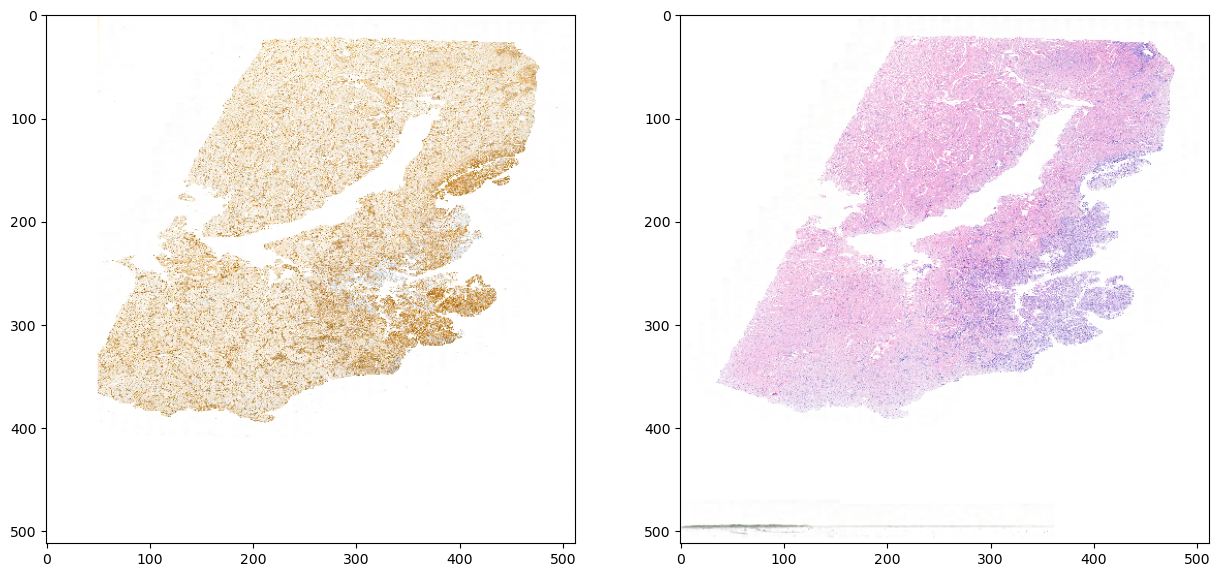

In [46]:
i=13
fileName=Transfer_df.loc[i]['slide']
stain=Transfer_df.loc[i]['stain']
x=Transfer_df.loc[i]['x']*100
y=Transfer_df.loc[i]['y']*100
angle=Transfer_df.loc[i]['angle']
he_slide = slideio.open_slide(HE_svs_path+fileName+'.svs', "SVS")
stain_slide = slideio.open_slide(stain_svs_path+stain+'/'+fileName+'.svs', "SVS")
scene = he_slide.get_scene(0)
svsWidth = scene.rect[2]
svsHeight = scene.rect[3]
he_slide_block = scene.read_block((0, 0, svsWidth, svsHeight),size=(int(512), int(512)))
scene = stain_slide.get_scene(0)
stain_slide_block = scene.read_block((x, y, svsWidth, svsHeight),size=(int(512), int(512)))
plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(stain_slide_block)
plt.subplot(1,2,2)
plt.imshow(he_slide_block)

In [48]:
Transfer_df

,slide,stain,x,y,angle
0,S21-21487-5,CD10,-16,480,-4
1,S21-30016-12,CD10,-10,-290,13
2,S22-08675-2,CD10,-60,-760,186
3,S21-12872-4,CD31,-50,-240,5
4,S21-20563-21,CK7,-180,500,3
5,S21-12872-4,D2-40,110,-860,1
6,S22-08675-2,Desmin,-180,-1310,178
7,S21-30506-6,Ki67,100,-740,3
8,S21-20563-21,P16,30,210,-3
9,S21-20563-23,P16,335,65,170


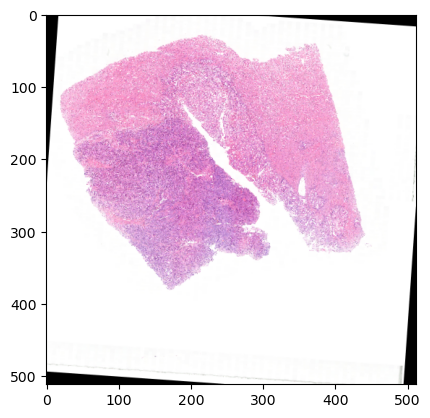

In [39]:
rotate=angle

(h, w) = he_slide_block.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), rotate, 1.0)
rotated = cv2.warpAffine(he_slide_block, M, (w, h))
plt.imshow(rotated)